# Importing Python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import emcee

plt.rcParams['text.usetex']= True
plt.rcParams["font.family"] = "rm"

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing self-written functions

In [ ]:
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parent
print(f'root directory: {PROJECT_ROOT}')
sys.path.insert(0, str(PROJECT_ROOT / "packages"))  # moving directory to 'packages' folder to import functions
print(f'current system path: {sys.path[0]}')

from conversions_calculations_and_constants.calculations import SFR_Ha, SFR_UV, log_SFR_mass_Speagle2014, log_SFR_mass_Popesso2023
from conversions_calculations_and_constants.conversions import M_AB_to_L_nu, f_lambda_to_luminosity

root directory: /Users/MarissaPerry/Documents/undergrad/projects/capstone
current system path: /Users/MarissaPerry/Documents/undergrad/projects/capstone/packages


# Loading in data

In [3]:
sample_df = pd.read_csv('../outputs/checkpoints/sample_Balmer_UV_mass.csv')

# literature data
Clarke2024_z12 = pd.read_csv('../data/clarke2024_frac_vals/clarke2024_z12.csv',names=['x', 'y'])
Clarke2024_z24 = pd.read_csv('../data/clarke2024_frac_vals/clarke2024_z24.csv',names=['x', 'y'])
Clarke2024_z45 = pd.read_csv('../data/clarke2024_frac_vals/clarke2024_z45.csv',names=['x', 'y'])
Clarke2024_z56 = pd.read_csv('../data/clarke2024_frac_vals/clarke2024_z56.csv',names=['x', 'y'])
Clarke2024_z67 = pd.read_csv('../data/clarke2024_frac_vals/clarke2024_z67.csv',names=['x', 'y'])

# adding "Z BIN" column to each dataframe
Clarke2024_z12['Z BIN'] = '1-2.5'
Clarke2024_z24['Z BIN'] = '2.5-4'
Clarke2024_z45['Z BIN'] = '4-5.5'
Clarke2024_z56['Z BIN'] = '5.5-7'
Clarke2024_z67['Z BIN'] = '5.5-7'

# combining dataframes
Clarke2024_df = pd.concat([Clarke2024_z12, Clarke2024_z24, Clarke2024_z45, Clarke2024_z56, Clarke2024_z67], ignore_index=True)

print('max redshift:',max(sample_df['Z SPEC']))
print('min redshift:',min(sample_df['Z SPEC']))
print('min stellar mass:',min(sample_df['MASS MEDIAN']))
print('max stellar mass:',max(sample_df['MASS MEDIAN']))
print('median stellar mass:',np.median(sample_df['MASS MEDIAN']))

max redshift: 6.990099906921387
min redshift: 0.7770000100135803
min stellar mass: 7.039009720076924
max stellar mass: 10.853661780842874
median stellar mass: 8.591230506580342


# Binning and sorting dataframe by redshift

In [4]:
z_bins = ['1-2.5', '2.5-4', '4-5.5', '5.5-7']
redshifts = [0, 2.5, 4, 5.5, 7.1]
sample_df['Z BIN'] = pd.cut(sample_df['Z SPEC'], bins=redshifts, labels=z_bins, right=False)
sample_df.sort_values(by=['Z BIN'], inplace=True)

label_list = ['z = 1 - 2.5','z = 2.5 - 4','z = 4 - 5.5','z = 5.5 - 7']

# gradient of colors for the bins
start_color = np.array(mcolors.to_rgb('#EF745C'))  
end_color = np.array(mcolors.to_rgb('#34073D'))  

num_bins = len(z_bins)
color_list = [start_color + (end_color - start_color) * i / (len(z_bins) - 1) for i in range(len(z_bins))]

sample_df

,MSA ID,SURVEY,SPECTRA TYPE,Z SPEC,RA,DEC,H-ALPHA INTEGRATED LUMINOSITY,H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR,H-ALPHA INTEGRATED LUMINOSITY 16% ERROR,H-ALPHA INTEGRATED LUMINOSITY 84% ERROR,...,UV LUMINOSITY DENSITY DUST-CORRECTED 16% ERROR,UV LUMINOSITY DUST-CORRECTED 16% ERROR,UV LUMINOSITY DENSITY DUST-CORRECTED MEDIAN,UV LUMINOSITY DUST-CORRECTED MEDIAN,UV LUMINOSITY DENSITY DUST-CORRECTED 84% ERROR,UV LUMINOSITY DUST-CORRECTED 84% ERROR,UV LUMINOSITY DENSITY DUST-CORRECTED MEAN ERROR,UV LUMINOSITY DUST-CORRECTED MEAN ERROR,UV LUMINOSITY SNR,Z BIN
171,35478,RUBIES,PRISM,1.801400,214.855202,52.814632,5.279883e+42,2.074053e+41,2.075253e+41,2.073221e+41,...,9.190965e+28,6.265330e+42,9.504448e+28,1.899575e+44,9.857593e+28,7.058018e+42,3.333143e+27,6.661674e+42,28.514974,1-2.5
78,17463,CEERS,GRATING,2.302000,215.050125,52.941961,2.023637e+41,1.388530e+40,1.361146e+40,1.416390e+40,...,2.624659e+27,3.020991e+41,2.775813e+27,5.547786e+42,2.922153e+27,2.924763e+41,1.487468e+26,2.972877e+41,18.661337,1-2.5
198,41376,RUBIES,PRISM,2.302900,214.829378,52.811732,5.098354e+41,2.498603e+40,2.611906e+40,2.427810e+40,...,8.739740e+27,7.074261e+41,9.093697e+27,1.817481e+43,9.523405e+27,8.588206e+41,3.918327e+26,7.831233e+41,23.208111,1-2.5
208,42538,RUBIES,PRISM,1.987400,34.271604,-5.242305,6.109398e+41,1.104923e+41,1.108940e+41,1.102039e+41,...,6.013385e+28,4.077098e+42,6.217381e+28,1.242616e+44,6.400742e+28,3.664683e+42,1.936785e+27,3.870891e+42,32.101552,1-2.5
67,10293,CEERS,GRATING,1.676000,214.872556,52.875949,2.640052e+41,5.569706e+40,5.562211e+40,5.580040e+40,...,8.306592e+26,3.646991e+41,1.013135e+27,2.024868e+42,1.271612e+27,5.165964e+41,2.204764e+26,4.406477e+41,4.595208,1-2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,32524,RUBIES,PRISM,5.648329,214.820636,52.783304,5.226272e+41,5.714102e+40,5.599890e+40,5.833109e+40,...,1.393816e+28,2.666465e+42,1.527232e+28,3.052350e+43,1.665509e+28,2.763641e+42,1.358466e+27,2.715053e+42,11.242323,5.5-7
164,32291,RUBIES,PRISM,6.584500,214.831575,52.790551,5.662719e+41,1.418337e+41,1.280926e+41,1.560614e+41,...,1.811209e+28,5.512506e+42,2.087025e+28,4.171163e+43,2.375488e+28,5.765257e+42,2.821392e+27,5.638881e+42,7.397146,5.5-7
159,30434,RUBIES,PRISM AND GRATING,5.678600,34.270243,-5.262327,6.690314e+41,1.368235e+41,1.307279e+41,1.431736e+41,...,4.379759e+28,1.017703e+43,4.888963e+28,9.771161e+43,5.322062e+28,8.655985e+42,4.711514e+27,9.416510e+42,10.376627,5.5-7
209,42573,RUBIES,GRATING,6.493300,214.970177,52.916446,1.281671e+42,9.623014e+40,9.799090e+40,9.512085e+40,...,7.238549e+28,4.701082e+42,7.473766e+28,1.493719e+44,7.755796e+28,5.636700e+42,2.586235e+27,5.168891e+42,28.898252,5.5-7


In [5]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
bins = sample_df['Z BIN'].unique()
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

In [6]:
bins = sample_df['Z BIN'].unique()

for i, bin in enumerate(bins):

    # dataframe of current bin
    df = df_split_by_bins[bin]
    print(len(df))

58
112
103
70


# Calculating SFR(H-alpha)

In [7]:
SFR_Has = SFR_Ha(sample_df['H-ALPHA INTEGRATED LUMINOSITY'])
SFR_UVs = SFR_UV(sample_df['UV LUMINOSITY DENSITY DUST-CORRECTED MEDIAN'])
SFR_Ha_errs = SFR_Ha(sample_df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR'])
SFR_UV_errs = SFR_UV(sample_df['UV LUMINOSITY DENSITY DUST-CORRECTED MEAN ERROR'])

sample_df.insert(7, 'H-ALPHA SFR', SFR_Has)            # adding column at the beginning of Balmer emission columns
sample_df.insert(8, 'H-ALPHA SFR ERROR', SFR_Ha_errs)  # ''
sample_df.insert(9, 'UV SFR', SFR_UVs)                 # ''
sample_df.insert(10, 'UV SFR ERROR', SFR_UV_errs)      # ''

# Calculate Ha-to-UV luminosity ratio

In [8]:
UV_lum = sample_df['UV LUMINOSITY DUST-CORRECTED MEDIAN']
Ha_lum = sample_df['H-ALPHA INTEGRATED LUMINOSITY']
UV_lum_err = sample_df['UV LUMINOSITY DUST-CORRECTED MEAN ERROR']
Ha_lum_err = sample_df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR']

# actual ratio
lum_ratio = Ha_lum / UV_lum
log_lum_ratio = np.log10(lum_ratio).tolist()

# error propagation
relative_error_UV = UV_lum_err / UV_lum
relative_error_Ha = Ha_lum_err / Ha_lum
    
# propagate error in ratio
lum_ratio_error = np.sqrt(relative_error_UV**2 + relative_error_Ha**2) * lum_ratio
# propagate error in logarithm
log_lum_ratio_error = ((lum_ratio_error / lum_ratio) * (1 / np.log(10))).tolist()
    
sample_df.insert(5, 'H-ALPHA-TO-UV LUMINOSITY RATIO', lum_ratio)   # adding column at the beginning of emission columns
sample_df.insert(6, 'H-ALPHA-TO-UV LUMINOSITY RATIO ERROR', lum_ratio_error) 
sample_df.insert(7, 'LOG H-ALPHA-TO-UV LUMINOSITY RATIO', log_lum_ratio) 
sample_df.insert(8, 'LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR', log_lum_ratio_error) 

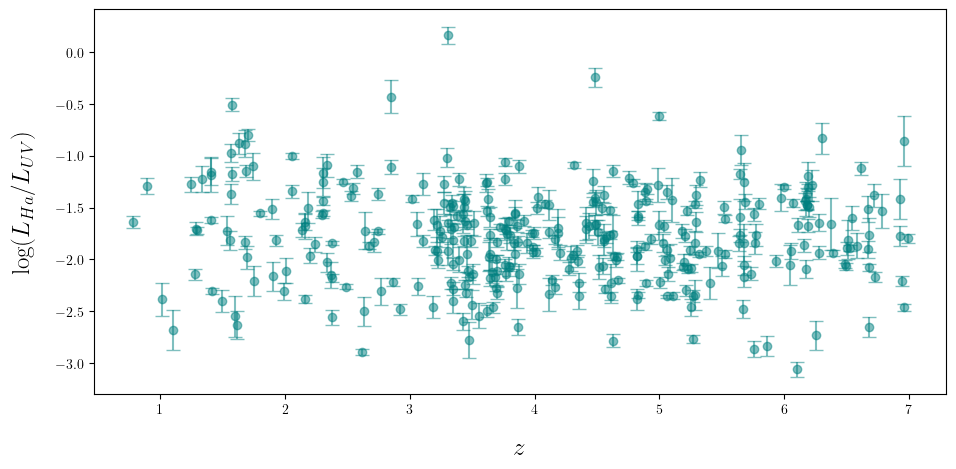

In [9]:
plt.figure(figsize=(11,5))
plt.xlabel(r'$z$',fontsize=18, labelpad=15)
plt.ylabel(r'log($L_{Ha}$/$L_{UV}$)',fontsize=18, labelpad=15) 
plt.errorbar(sample_df['Z SPEC'], sample_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'], yerr=sample_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR'], color='teal', alpha=0.5, fmt = 'o', markersize=6, capsize=5)
plt.savefig('../outputs/plots/redshift_luminosity_ratio.png',dpi=500,bbox_inches='tight')
plt.show()

# Computing the limiting SFR

In [10]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
bins = sample_df['Z BIN'].unique()
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

In [ ]:
# values from Finkelstein+2025, Table 5 and 6 --------------
G395M_emission_line_5_sigma_depth = 1.1e-18  # [erg/s/cm^2]   also using PRISM, but Medium Grating will be best to represent the lower limit
# NIRCam_median_catalog_5_sigma_depth = 28.5   # [AB mag]       From Table 5, we focus on NIRCam filters relevant for capturing rest-frame 1500 Å at different redshifts: (F200W, F277W, F356W)

# converting to luminosities -------------------------------
SFR_Ha_limit = []
SFR_UV_limit = []
for i, bin in enumerate(bins):

    # dataframe of current bin
    df = df_split_by_bins[bin]

    # computing redshift percentiles ------------
    z_bin_median = df['Z SPEC'].quantile(q=0.50)
    # -------------------------------------------

    # SFR(Ha) limit ----------
    # converting f_lambda --> L
    L_Ha_limit = f_lambda_to_luminosity(G395M_emission_line_5_sigma_depth, z_bin_median)
    # converting L --> SFR
    SFR_Ha_vals = SFR_Ha(L_Ha_limit)
    SFR_Ha_limit.append(SFR_Ha_vals)
    # ------------------------
    
    # SFR(UV) limit ----------
    # saving the faintest reliably detected rest-frame UV source value
    M_lim = df['ABSOLUTE MAG 1500 16% ERROR'].max()
    # converting M_AB --> L_v
    L_UV_nu_limit = M_AB_to_L_nu(M_lim)
    # converting L_v --> SFR
    SFR_UV_vals = SFR_UV(L_UV_nu_limit)
    SFR_UV_limit.append(SFR_UV_vals)
    # ------------------------

    print(f"{bin}:")
    print(f"  Faintest SFR(UV): {df['UV SFR'].min():.2f}")
    print(f"  Limiting SFR(UV): {SFR_UV_vals:.2f}")

1-2.5:
  Faintest SFR(UV): 0.06
  Limiting SFR(UV): 0.07
2.5-4:
  Faintest SFR(UV): 0.13
  Limiting SFR(UV): 0.12
4-5.5:
  Faintest SFR(UV): 0.38
  Limiting SFR(UV): 0.20
5.5-7:
  Faintest SFR(UV): 0.55
  Limiting SFR(UV): 0.64


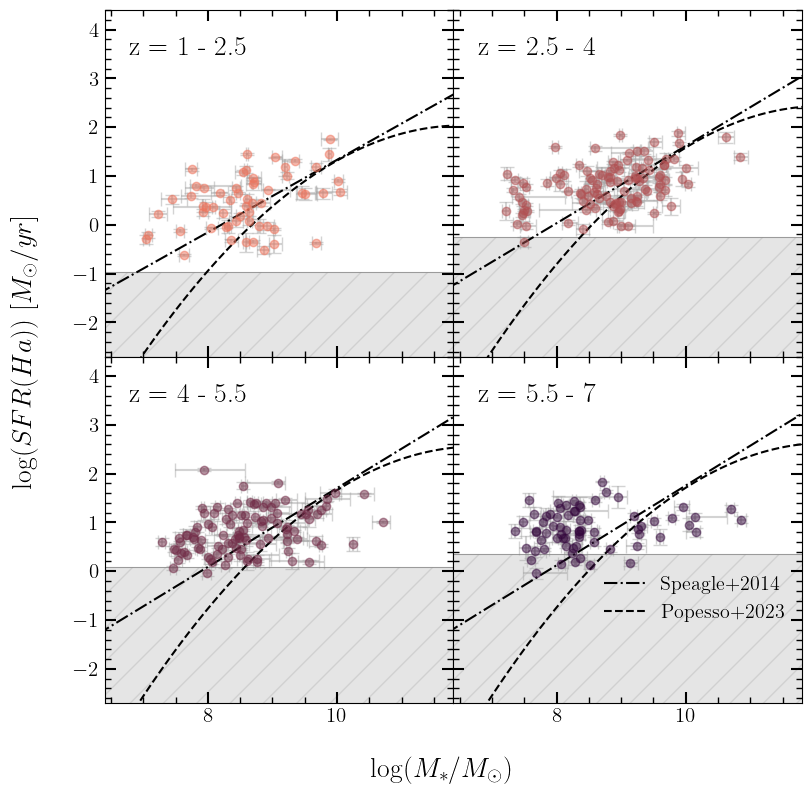

In [12]:
# Create 2x2 grid for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True)
fig.supxlabel(r'log($M_*$/$M_{\odot}$)', fontsize=20, y=0.02)
fig.supylabel(r'log($SFR(Ha)$) [$M_{\odot}/yr$]', fontsize=20, x=0.02)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]

    # data from of current z-bin
    df = df_split_by_bins[bin]

    xbot = df['MASS 16% ERROR']
    xtop = df['MASS 84% ERROR']
    x_data = df['MASS MEDIAN']
    y_data = np.log10(df['H-ALPHA SFR'])
    y_data_err = df['H-ALPHA SFR ERROR'] / (df['H-ALPHA SFR'] * np.log(10))  # propogate error


    # SFMS fit line
    x_arr = np.linspace(6, 12, 100)

    # data
    ax.errorbar(x_data, y_data, xerr=(xbot, xtop), yerr=y_data_err, color=color_list[i], ecolor='#A9A9A9', alpha=0.5, 
                fmt='o', markersize=6, capsize=5)

    # limiting SFR
    # ax.axhline(y=np.log10(SFR_Ha_limit_16th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.axhline(y=np.log10(SFR_Ha_limit[i]), color='grey', linestyle='solid', linewidth=0.5)
    # ax.axhline(y=np.log10(SFR_Ha_limit_84th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.fill_between(x_arr, -5, np.log10(SFR_Ha_limit[i]), color='grey',  hatch='/', alpha=0.2)

    # literature value
    x_arr = np.linspace(6, 12, 100).reshape((-1, 1))
    z_median = np.median(df['Z SPEC'])
    ax.plot(x_arr, log_SFR_mass_Speagle2014(x_arr, z_median), color='black', linestyle='-.', label='Speagle+2014')
    ax.plot(x_arr, log_SFR_mass_Popesso2023(x_arr, z_median), color='black', linestyle='--', label='Popesso+2023')
    
    ax.text(
        0.07, 0.87,  
        label_list[i], 
        color='black', 
        fontsize=20, 
        fontweight='heavy',
        transform=ax.transAxes  
    )

    if i == 3:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=14.5, loc=(0.41,0.21), frameon=False)
    
    ax.set_ylim(-2.7,4.4)
    ax.set_xlim(6.4,11.8)
    
    # adding major & minor ticks on all sides
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=8, width=1.5)
    
    # adding minor ticks
    ax.minorticks_on()
    ax.tick_params(axis="both", which="minor", direction="in", length=4, width=1.0, top=True, right=True)

plt.subplots_adjust(wspace=0, hspace=0)  
plt.show()

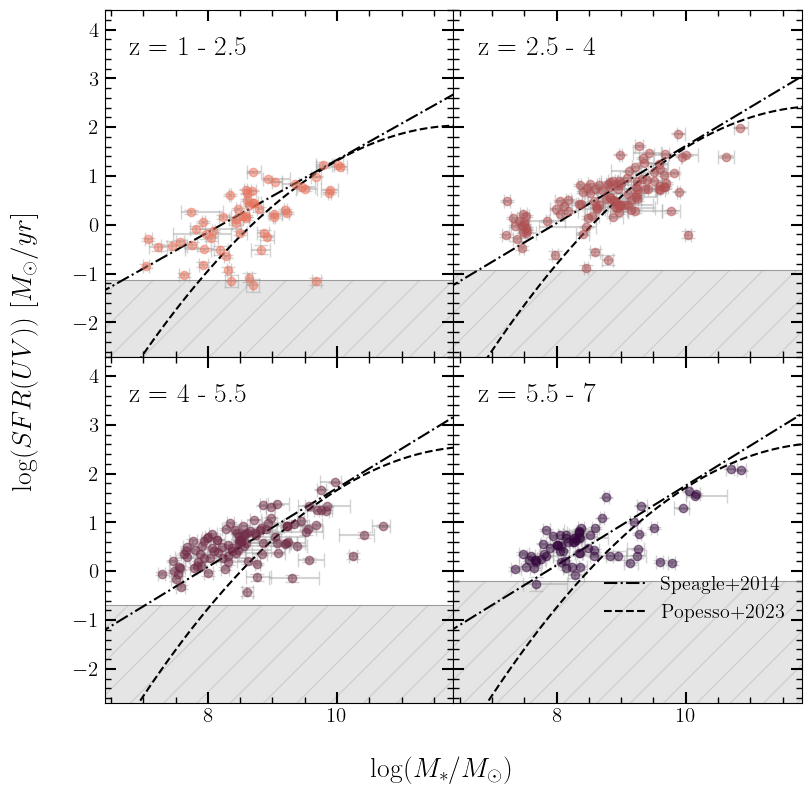

In [13]:
# Create 2x2 grid for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True)
fig.supxlabel(r'log($M_*$/$M_{\odot}$)', fontsize=20, y=0.02)
fig.supylabel(r'log($SFR(UV)$) [$M_{\odot}/yr$]', fontsize=20, x=0.02)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]

    # data from of current z-bin
    df = df_split_by_bins[bin]

    xbot = df['MASS 16% ERROR']
    xtop = df['MASS 84% ERROR']
    x_data = df['MASS MEDIAN']
    y_data = np.log10(df['UV SFR'])
    y_data_err = df['UV SFR ERROR'] / (df['UV SFR'] * np.log(10))  # propogate error


    # SFMS fit line
    x_arr = np.linspace(6, 12, 100)

    # data
    ax.errorbar(x_data, y_data, xerr=(xbot, xtop), yerr=y_data_err, color=color_list[i], ecolor='#A9A9A9', alpha=0.5, 
                fmt='o', markersize=6, capsize=5)

    # limiting SFR
    # ax.axhline(y=np.log10(SFR_Ha_limit_16th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.axhline(y=np.log10(SFR_UV_limit[i]), color='grey', linestyle='solid', linewidth=0.5)
    # ax.axhline(y=np.log10(SFR_Ha_limit_84th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.fill_between(x_arr, -5, np.log10(SFR_UV_limit[i]), color='grey',  hatch='/', alpha=0.2)

    # literature value
    x_arr = np.linspace(6, 12, 100).reshape((-1, 1))
    z_median = np.median(df['Z SPEC'])
    ax.plot(x_arr, log_SFR_mass_Speagle2014(x_arr, z_median), color='black', linestyle='-.', label='Speagle+2014')
    ax.plot(x_arr, log_SFR_mass_Popesso2023(x_arr, z_median), color='black', linestyle='--', label='Popesso+2023')
    
    ax.text(
        0.07, 0.87,  
        label_list[i], 
        color='black', 
        fontsize=20, 
        fontweight='heavy',
        transform=ax.transAxes  
    )

    if i == 3:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=14.5, loc=(0.41,0.21), frameon=False)
    
    ax.set_ylim(-2.7,4.4)
    ax.set_xlim(6.4,11.8)
    
    # adding major & minor ticks on all sides
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=8, width=1.5)
    
    # adding minor ticks
    ax.minorticks_on()
    ax.tick_params(axis="both", which="minor", direction="in", length=4, width=1.0, top=True, right=True)

plt.subplots_adjust(wspace=0, hspace=0)  
plt.show()

# Fitting the SFMS

In [14]:
def linear_model(x, m, b):
    pivot_point = 8.6
    return m * (x - pivot_point) + b

def sigmoid_completeness(y, SFR_limit, alpha=5):
    return 1.0 / (1.0 + np.exp(-alpha * (y - SFR_limit)))

def log_likelihood(theta, x, y, yerr, SFR_limit, pivot, alpha=5):
    m, b, lnf = theta
    model = m * (x - pivot) + b
    sigma2 = yerr**2 + np.exp(2 * lnf)
    
    completeness = sigmoid_completeness(y, SFR_limit, alpha)
    completeness = np.clip(completeness, 1e-10, 1.0)  # avoid log(0)
    
    return -0.5 * np.sum(((y - model)**2 / sigma2 + np.log(sigma2)) - 2 * np.log(completeness))

def log_prior(theta):
    m, b, lnf = theta
    if not (0.5 <= m <= 1.5): return -np.inf
    if not -5 <= b <= 5: return -np.inf
    if not -10 <= lnf <= np.log(1.5): return -np.inf
    return 0.0

def log_probability(theta, x, y, yerr, SFR_limit, pivot):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, SFR_limit, pivot)

In [15]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

100%|██████████| 5000/5000 [00:38<00:00, 130.38it/s]


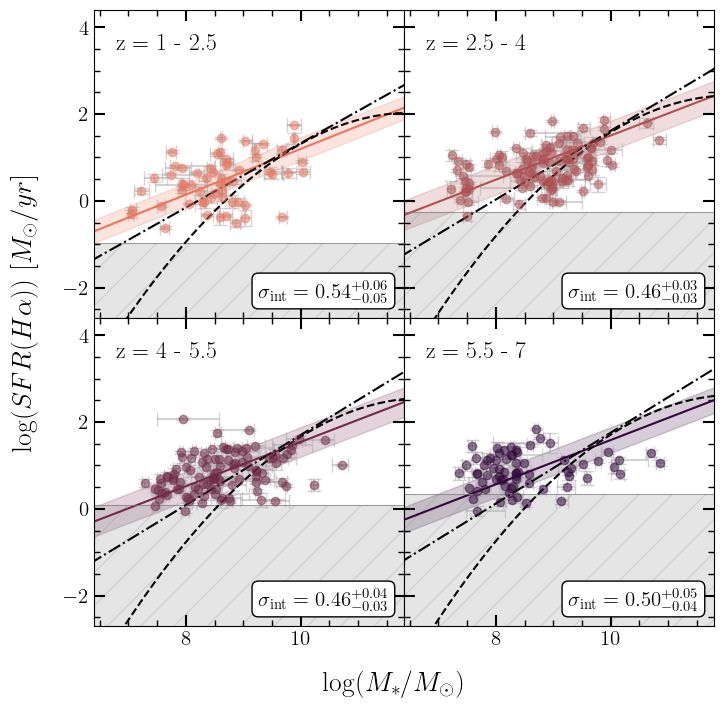

,Z BIN,SLOPE,SLOPE LOWER ERROR,SLOPE UPPER ERROR,INTERCEPT,INTERCEPT LOWER ERROR,INTERCEPT UPPER ERROR,INTRINSIC SCATTER,SCATTER LOWER ERROR,SCATTER UPPER ERROR
0,1-2.5,0.527315,0.019959,0.042264,0.459166,0.066575,0.073387,0.541463,0.048720,0.056064
1,2.5-4,0.508940,0.006462,0.014134,0.793731,0.043203,0.042482,0.455245,0.029999,0.033705
2,4-5.5,0.509715,0.007370,0.014641,0.828432,0.043693,0.044401,0.457556,0.031010,0.035158
3,5.5-7,0.510556,0.007743,0.016264,0.871910,0.062891,0.061740,0.504295,0.041570,0.048485


In [16]:
sfms_results = []

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
fig.supxlabel(r'log($M_*$/$M_{\odot}$)', fontsize=20, y=0.02)
fig.supylabel(r'log($SFR(H\alpha)$) [$M_{\odot}/yr$]', fontsize=20, x=0.02)

for i, bin in enumerate(bins):
    df = df_split_by_bins[bin]
    ax = axs[i // 2, i % 2]

    x_data = df['MASS MEDIAN']
    xtop = df['MASS 16% ERROR']
    xbot = df['MASS 84% ERROR']
    y_data = np.log10(df['H-ALPHA SFR'])
    y_data_err = df['H-ALPHA SFR ERROR'] / (df['H-ALPHA SFR'] * np.log(10))
    SFR_limit = np.log10(SFR_Ha_limit[i])

    pivot = np.mean(x_data)
    nwalkers = 20
    ndim = 3

    m_init = np.random.uniform(0.5, 1.5, nwalkers)
    b_init = np.random.uniform(-2.0, 2.0, nwalkers)
    lnf_init = np.random.uniform(-3.0, -1.0, nwalkers)
    p0 = np.vstack((m_init, b_init, lnf_init)).T

    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability,
        args=(x_data, y_data, y_data_err, SFR_limit, pivot)
    )
    sampler.run_mcmc(p0, 5000, progress=True)

    samples = sampler.get_chain(discard=3000, thin=15, flat=True)
    m_mcmc, b_mcmc, lnf_mcmc = np.percentile(samples, 50, axis=0)
    m_16, m_84 = np.percentile(samples[:, 0], [16, 84])
    b_16, b_84 = np.percentile(samples[:, 1], [16, 84])
    lnf_16, lnf_84 = np.percentile(samples[:, 2], [16, 84])

    f_mcmc = np.exp(lnf_mcmc)
    f_16 = np.exp(lnf_16)
    f_84 = np.exp(lnf_84)

    sfms_results.append({
        "Z BIN": bin,
        "SLOPE": m_mcmc,
        "SLOPE LOWER ERROR": m_mcmc - m_16,
        "SLOPE UPPER ERROR": m_84 - m_mcmc,
        "INTERCEPT": b_mcmc,
        "INTERCEPT LOWER ERROR": b_mcmc - b_16,
        "INTERCEPT UPPER ERROR": b_84 - b_mcmc,
        "INTRINSIC SCATTER": f_mcmc,
        "SCATTER LOWER ERROR": f_mcmc - f_16,
        "SCATTER UPPER ERROR": f_84 - f_mcmc
    })

    x_arr = np.linspace(6, 12, 100)
    y_model = linear_model(x_arr, m_mcmc, b_mcmc)

    y_scatter_upper = y_model + np.log10(f_mcmc)
    y_scatter_lower = y_model - np.log10(f_mcmc)

    ax.errorbar(x_data, y_data, xerr=(xtop, xbot), yerr=y_data_err, color=color_list[i], ecolor='#A9A9A9', alpha=0.5,
                fmt='o', markersize=6, capsize=5)
    ax.plot(x_arr, y_model, color=color_list[i], linestyle='-')
    ax.fill_between(x_arr, y_scatter_lower, y_scatter_upper, color=color_list[i], alpha=0.2)

    # limiting SFR
    # ax.axhline(y=np.log10(SFR_Ha_limit_16th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.axhline(y=np.log10(SFR_Ha_limit[i]), color='grey', linestyle='solid', linewidth=0.5)
    # ax.axhline(y=np.log10(SFR_Ha_limit_84th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.fill_between(x_arr, -5, np.log10(SFR_Ha_limit[i]), color='grey',  hatch='/', alpha=0.2)

    # literature values
    z_median = np.median(df['Z SPEC'])
    ax.plot(x_arr, log_SFR_mass_Speagle2014(x_arr, z_median), color='black', linestyle='-.', label='Speagle+2014')
    ax.plot(x_arr, log_SFR_mass_Popesso2023(x_arr, z_median), color='black', linestyle='--', label='Popesso+2023')

    ax.text(0.95, 0.05, rf"$\sigma_{{\rm int}} = {f_mcmc:.2f}^{{+{f_84-f_mcmc:.2f}}}_{{-{f_mcmc-f_16:.2f}}}$",
            transform=ax.transAxes, fontsize=15, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.text(0.07, 0.87, label_list[i], color='black', fontsize=17, fontweight='heavy', transform=ax.transAxes)
    ax.set_xlim(6.4, 11.8)
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=8, width=1.5)
    ax.minorticks_on()
    ax.tick_params(axis="both", which="minor", direction="in", length=4, width=1.0, top=True, right=True)

    ax.set_ylim(-2.7,4.4)
    ax.set_xlim(6.4,11.8)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

SFMS_Ha_df = pd.DataFrame(sfms_results)
SFMS_Ha_df

100%|██████████| 5000/5000 [00:39<00:00, 127.72it/s]


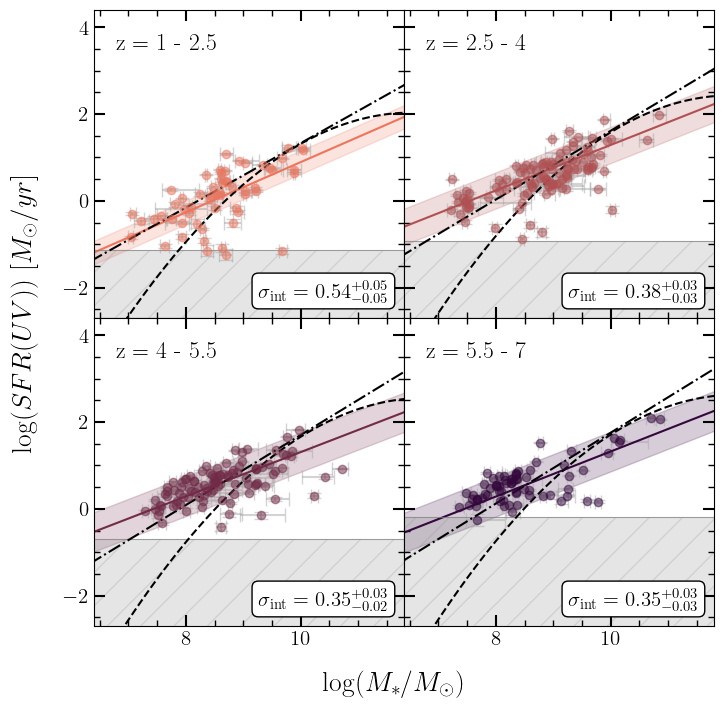

,Z BIN,SLOPE,SLOPE LOWER ERROR,SLOPE UPPER ERROR,INTERCEPT,INTERCEPT LOWER ERROR,INTERCEPT UPPER ERROR,INTRINSIC SCATTER,SCATTER LOWER ERROR,SCATTER UPPER ERROR
0,1-2.5,0.578645,0.054491,0.078366,0.082702,0.067847,0.069882,0.535127,0.046992,0.054215
1,2.5-4,0.523671,0.016533,0.029564,0.555083,0.035900,0.034782,0.382305,0.025561,0.028324
2,4-5.5,0.510269,0.007613,0.015352,0.594087,0.034399,0.034944,0.351093,0.023197,0.025413
3,5.5-7,0.519234,0.014337,0.026101,0.595849,0.040685,0.039961,0.347887,0.028549,0.032467


In [17]:
sfms_results = []

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
fig.supxlabel(r'log($M_*$/$M_{\odot}$)', fontsize=20, y=0.02)
fig.supylabel(r'log($SFR(UV)$) [$M_{\odot}/yr$]', fontsize=20, x=0.02)

for i, bin in enumerate(bins):
    df = df_split_by_bins[bin]
    ax = axs[i // 2, i % 2]

    x_data = df['MASS MEDIAN']
    xtop = df['MASS 16% ERROR']
    xbot = df['MASS 84% ERROR']
    y_data = np.log10(df['UV SFR'])
    y_data_err = df['UV SFR ERROR'] / (df['UV SFR'] * np.log(10))
    SFR_limit = np.log10(SFR_UV_limit[i])

    pivot = np.mean(x_data)
    nwalkers = 20
    ndim = 3

    m_init = np.random.uniform(0.5, 1.5, nwalkers)
    b_init = np.random.uniform(-2.0, 2.0, nwalkers)
    lnf_init = np.random.uniform(-3.0, -1.0, nwalkers)
    p0 = np.vstack((m_init, b_init, lnf_init)).T

    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability,
        args=(x_data, y_data, y_data_err, SFR_limit, pivot)
    )
    sampler.run_mcmc(p0, 5000, progress=True)

    samples = sampler.get_chain(discard=3000, thin=15, flat=True)
    m_mcmc, b_mcmc, lnf_mcmc = np.percentile(samples, 50, axis=0)
    m_16, m_84 = np.percentile(samples[:, 0], [16, 84])
    b_16, b_84 = np.percentile(samples[:, 1], [16, 84])
    lnf_16, lnf_84 = np.percentile(samples[:, 2], [16, 84])

    f_mcmc = np.exp(lnf_mcmc)
    f_16 = np.exp(lnf_16)
    f_84 = np.exp(lnf_84)

    sfms_results.append({
        "Z BIN": bin,
        "SLOPE": m_mcmc,
        "SLOPE LOWER ERROR": m_mcmc - m_16,
        "SLOPE UPPER ERROR": m_84 - m_mcmc,
        "INTERCEPT": b_mcmc,
        "INTERCEPT LOWER ERROR": b_mcmc - b_16,
        "INTERCEPT UPPER ERROR": b_84 - b_mcmc,
        "INTRINSIC SCATTER": f_mcmc,
        "SCATTER LOWER ERROR": f_mcmc - f_16,
        "SCATTER UPPER ERROR": f_84 - f_mcmc
    })

    x_arr = np.linspace(6, 12, 100)
    y_model = linear_model(x_arr, m_mcmc, b_mcmc)

    y_scatter_upper = y_model + np.log10(f_mcmc)
    y_scatter_lower = y_model - np.log10(f_mcmc)

    ax.errorbar(x_data, y_data, xerr=(xtop, xbot), yerr=y_data_err, color=color_list[i], ecolor='#A9A9A9', alpha=0.5,
                fmt='o', markersize=6, capsize=5)
    ax.plot(x_arr, y_model, color=color_list[i], linestyle='-')
    ax.fill_between(x_arr, y_scatter_lower, y_scatter_upper, color=color_list[i], alpha=0.2)

    # limiting SFR
    # ax.axhline(y=np.log10(SFR_Ha_limit_16th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.axhline(y=np.log10(SFR_UV_limit[i]), color='grey', linestyle='solid', linewidth=0.5)
    # ax.axhline(y=np.log10(SFR_Ha_limit_84th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.fill_between(x_arr, -5, np.log10(SFR_UV_limit[i]), color='grey',  hatch='/', alpha=0.2)

    # literature values
    z_median = np.median(df['Z SPEC'])
    ax.plot(x_arr, log_SFR_mass_Speagle2014(x_arr, z_median), color='black', linestyle='-.', label='Speagle+2014')
    ax.plot(x_arr, log_SFR_mass_Popesso2023(x_arr, z_median), color='black', linestyle='--', label='Popesso+2023')

    ax.text(0.95, 0.05, rf"$\sigma_{{\rm int}} = {f_mcmc:.2f}^{{+{f_84-f_mcmc:.2f}}}_{{-{f_mcmc-f_16:.2f}}}$",
            transform=ax.transAxes, fontsize=15, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.text(0.07, 0.87, label_list[i], color='black', fontsize=17, fontweight='heavy', transform=ax.transAxes)
    ax.set_xlim(6.4, 11.8)
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=8, width=1.5)
    ax.minorticks_on()
    ax.tick_params(axis="both", which="minor", direction="in", length=4, width=1.0, top=True, right=True)

    ax.set_ylim(-2.7,4.4)
    ax.set_xlim(6.4,11.8)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

SFMS_UV_df = pd.DataFrame(sfms_results)
SFMS_UV_df

In [18]:
SFMS_Ha_df.to_csv('../outputs/checkpoints/SFMS_Ha_df.csv',index=False)
SFMS_UV_df.to_csv('../outputs/checkpoints/SFMS_UV_df.csv',index=False)

# Calculate fraction of sample outside of equilibrium range of Ha-to-UV
- Getting errors on fractional measurements using Bootstrap method

In [19]:
def plot_bootstrap_distributions(frac_dist, measured_value, p16, p84, z_bin, mass_bin, label):
    """
    Visualize bootstrap histogram with median and percentile lines.
    
    Parameters:
        frac_dist (list): bootstrap samples
        measured_value (float): median of the distribution
        p16, p84 (float): 16th and 84th percentile values
        z_bin (str): redshift bin label
        mass_bin (str): stellar mass bin label
        label (str): 'above', 'below', or 'equilibrium'
    """
    plt.figure(figsize=(7, 5))
    plt.hist(frac_dist, bins=30, alpha=0.8, color='indianred', edgecolor='black')
    plt.axvline(measured_value, color='red', linestyle='--', label='Median $f_{}$'.format(label))
    plt.axvline(p16, color='black', linestyle=':', label='16th percentile')
    plt.axvline(p84, color='black', linestyle=':', label='84th percentile')
    
    plt.title(f'$z$ = {z_bin}, log(M*) = {mass_bin} ({label})', fontsize=13)
    plt.xlabel(f'Fraction {label}')
    plt.ylabel('Bootstrap samples')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
def bootstrap_pipeline_frac(sample_df, n_bootstraps=100):
    '''
    Bootstrap-based function to compute the fraction of galaxies above, below, and within
    the Hα-to-UV equilibrium range for redshift and mass bins, along with non-symmetric
    errors from bootstrap percentiles.

    Returns a DataFrame of results with consistent measured values and bootstrap uncertainties.
    '''
    equil_lower = -1.93
    equil_upper = -1.78

    # Define binning
    z_bins = ['1-2.5', '2.5-4', '4-5.5', '5.5-7']
    redshifts = [0, 2.5, 4, 5.5, 7.1]
    mass_bins = ['7-8.5', '8.5-10.9']
    masses = [6.5, 8.5, 11]

    # Add bin labels to DataFrame
    sample_df['Z BIN'] = pd.cut(sample_df['Z SPEC'], bins=redshifts, labels=z_bins, right=False)
    sample_df['MASS BIN'] = pd.cut(sample_df['MASS MEDIAN'], bins=masses, labels=mass_bins, right=False)

    # Initialize output
    results = {
        'Z BIN': [], 'MEDIAN Z': [], 'Z ERROR LOW': [], 'Z ERROR HIGH': [],
        'MASS BIN': [], 'TOTAL SOURCES': [],
        'FRAC ABOVE': [], 'FRAC ABOVE LOWER ERROR': [], 'FRAC ABOVE UPPER ERROR': [],
        'FRAC BELOW': [], 'FRAC BELOW LOWER ERROR': [], 'FRAC BELOW UPPER ERROR': [],
        'FRAC EQUILIBRIUM': [], 'FRAC EQUILIBRIUM LOWER ERROR': [], 'FRAC EQUILIBRIUM UPPER ERROR': []
    }

    for z_bin in z_bins:
        df_z_bin = sample_df[sample_df['Z BIN'] == z_bin]

        for m_bin in mass_bins:
            df_bin = df_z_bin[df_z_bin['MASS BIN'] == m_bin]
            if df_bin.empty:
                continue

            log_ratio = df_bin['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'].values
            log_ratio_err = df_bin['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR'].values
            total = len(log_ratio)

            # Median redshift + bounds
            median_z = np.median(df_bin['Z SPEC'])
            zmin, zmax = map(float, z_bin.split('-'))
            z_err_low = median_z - zmin
            z_err_high = zmax - median_z

            # Bootstrap distributions
            frac_above_dist, frac_below_dist, frac_within_dist = [], [], []

            for _ in range(n_bootstraps):
                perturbed = log_ratio + np.random.normal(loc=0.0, scale=log_ratio_err)
                resampled = np.random.choice(perturbed, size=total, replace=True)

                f_above = np.sum(resampled > equil_upper) / total
                f_below = np.sum(resampled < equil_lower) / total
                f_within = np.sum((resampled > equil_lower) & (resampled < equil_upper)) / total

                frac_above_dist.append(f_above)
                frac_below_dist.append(f_below)
                frac_within_dist.append(f_within)

            # Measured = median of distribution
            measured_above = np.median(frac_above_dist)
            measured_below = np.median(frac_below_dist)
            measured_within = np.median(frac_within_dist)

            # Asymmetric error bars
            p16_above, p84_above = np.percentile(frac_above_dist, [16, 84])
            p16_below, p84_below = np.percentile(frac_below_dist, [16, 84])
            p16_within, p84_within = np.percentile(frac_within_dist, [16, 84])

            plot_bootstrap_distributions(frac_above_dist, measured_above, p16_above, p84_above, z_bin, m_bin, 'above')
            plot_bootstrap_distributions(frac_below_dist, measured_below, p16_below, p84_below, z_bin, m_bin, 'below')
            plot_bootstrap_distributions(frac_within_dist, measured_within, p16_within, p84_within, z_bin, m_bin, 'equilibrium')

            # Store results
            results['Z BIN'].append(z_bin)
            results['MEDIAN Z'].append(median_z)
            results['Z ERROR LOW'].append(z_err_low)
            results['Z ERROR HIGH'].append(z_err_high)
            results['MASS BIN'].append(m_bin)
            results['TOTAL SOURCES'].append(total)

            results['FRAC ABOVE'].append(measured_above)
            results['FRAC ABOVE LOWER ERROR'].append(measured_above - p16_above)
            results['FRAC ABOVE UPPER ERROR'].append(p84_above - measured_above)

            results['FRAC BELOW'].append(measured_below)
            results['FRAC BELOW LOWER ERROR'].append(measured_below - p16_below)
            results['FRAC BELOW UPPER ERROR'].append(p84_below - measured_below)

            results['FRAC EQUILIBRIUM'].append(measured_within)
            results['FRAC EQUILIBRIUM LOWER ERROR'].append(measured_within - p16_within)
            results['FRAC EQUILIBRIUM UPPER ERROR'].append(p84_within - measured_within)

    return pd.DataFrame(results)

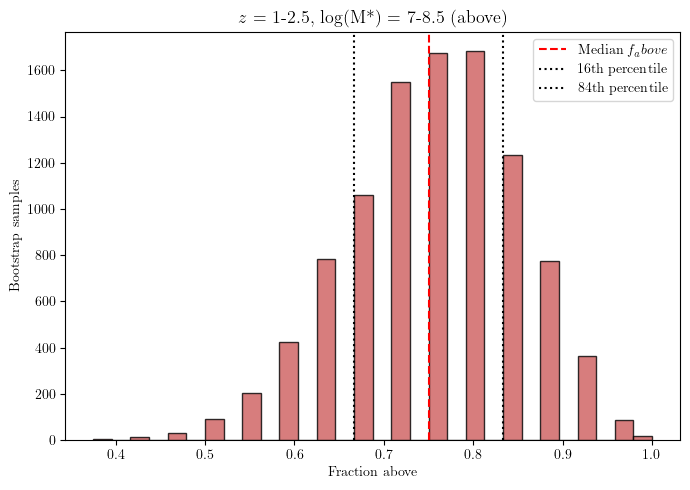

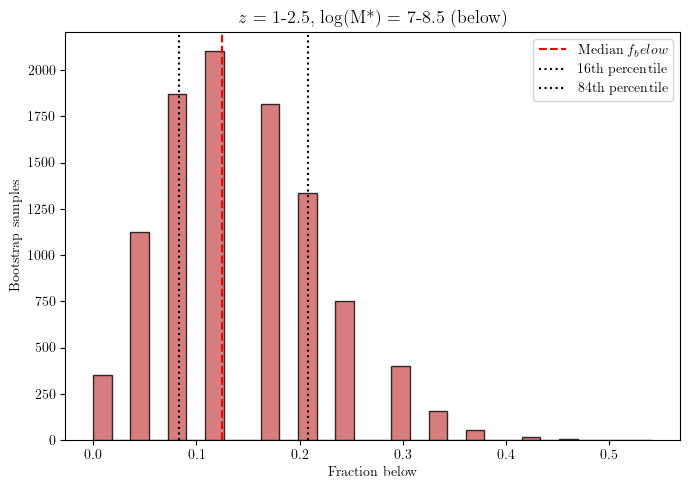

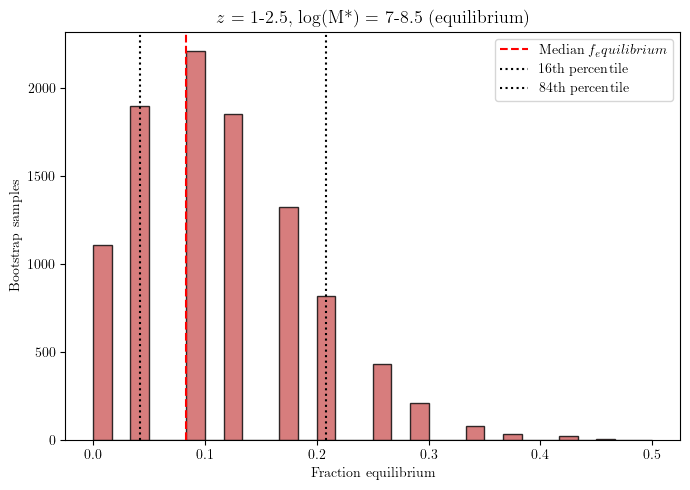

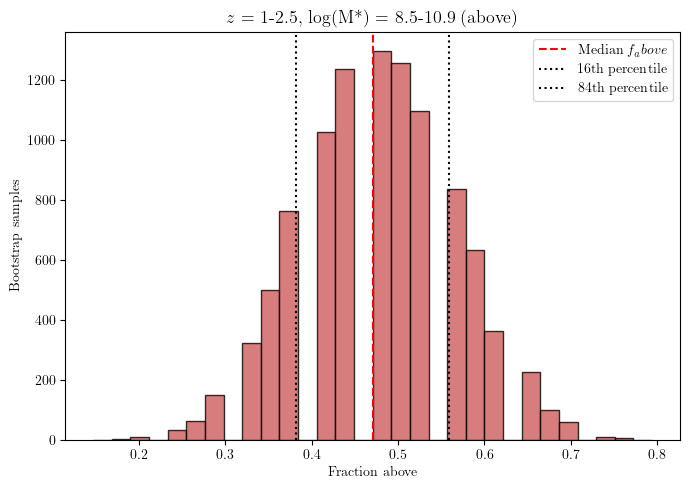

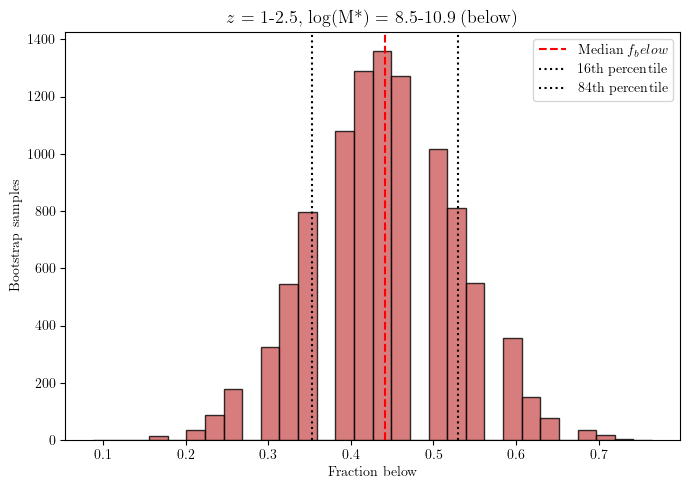

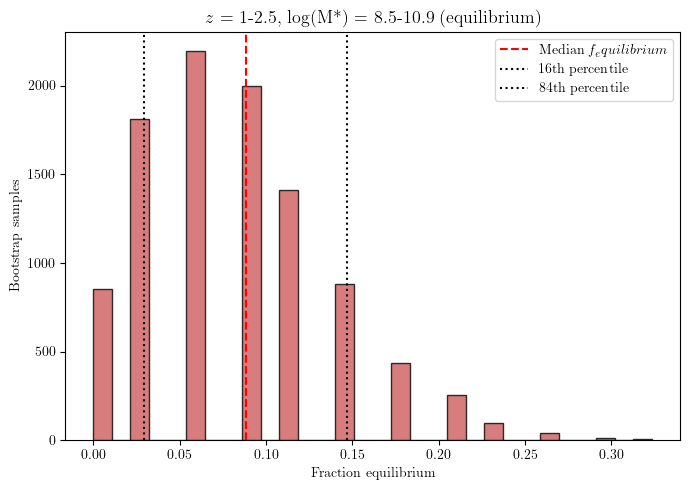

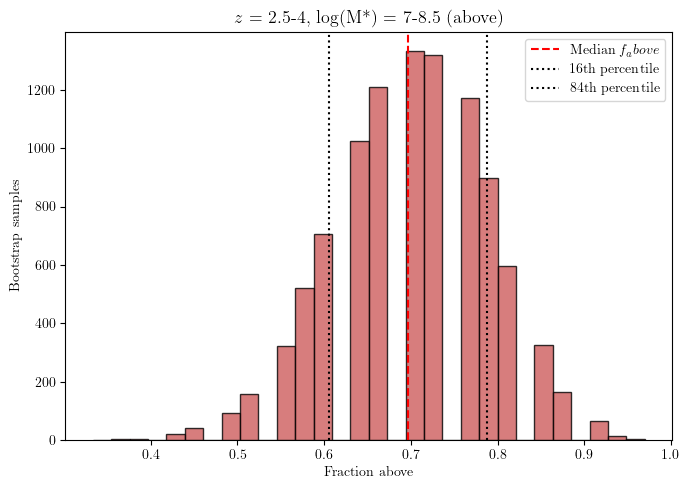

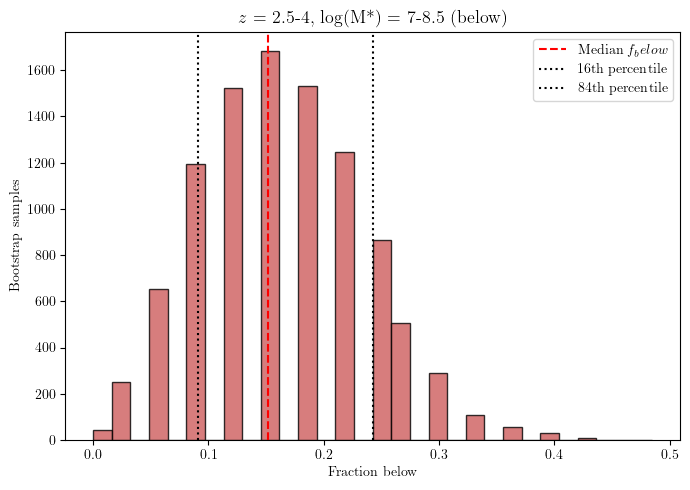

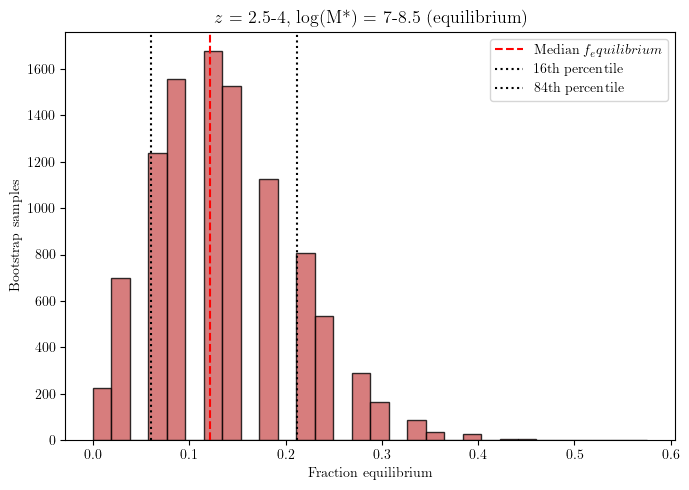

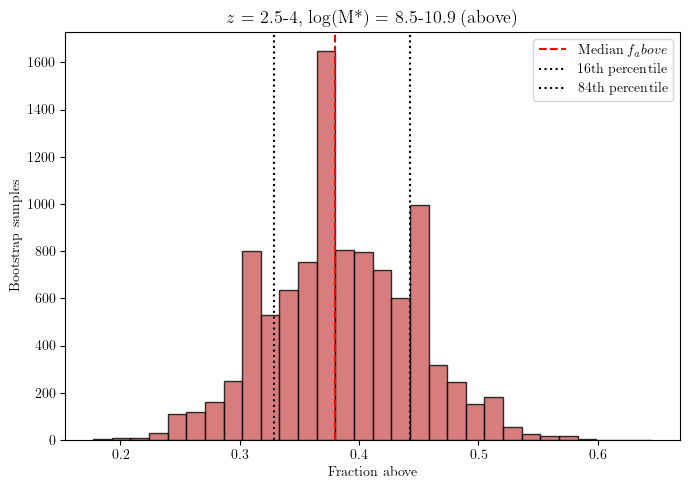

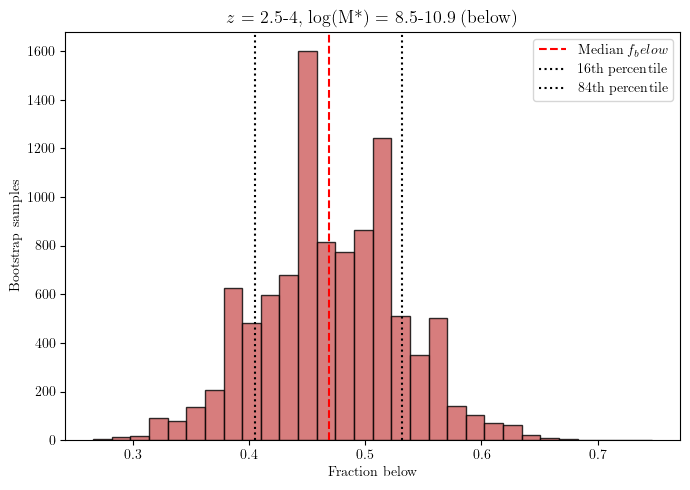

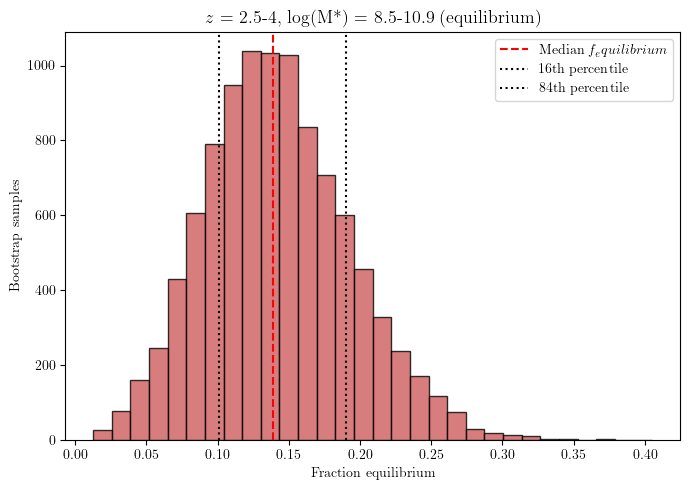

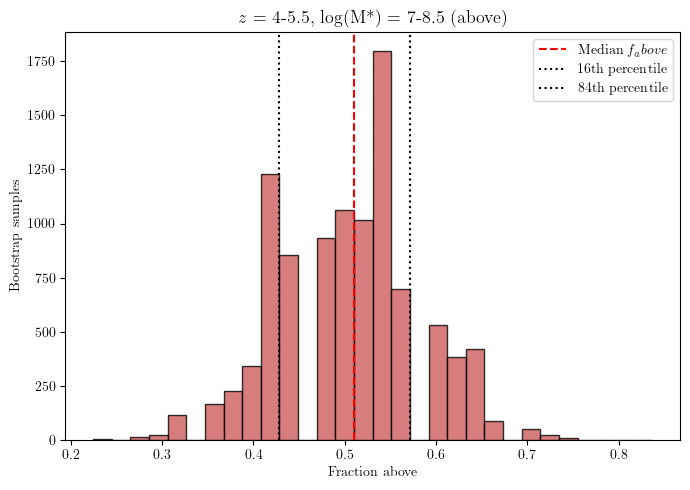

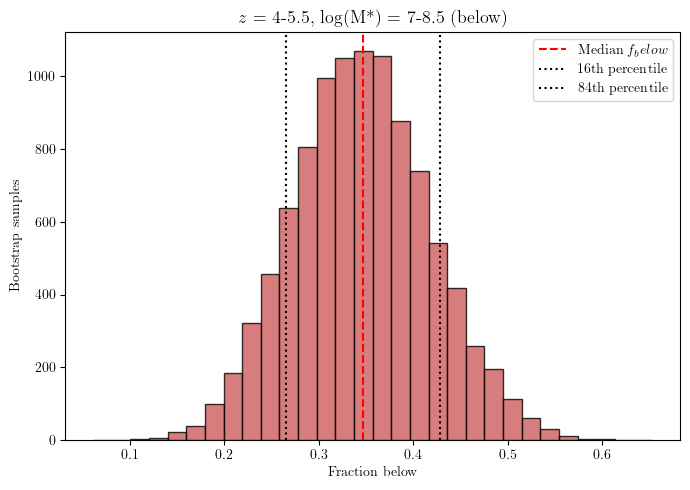

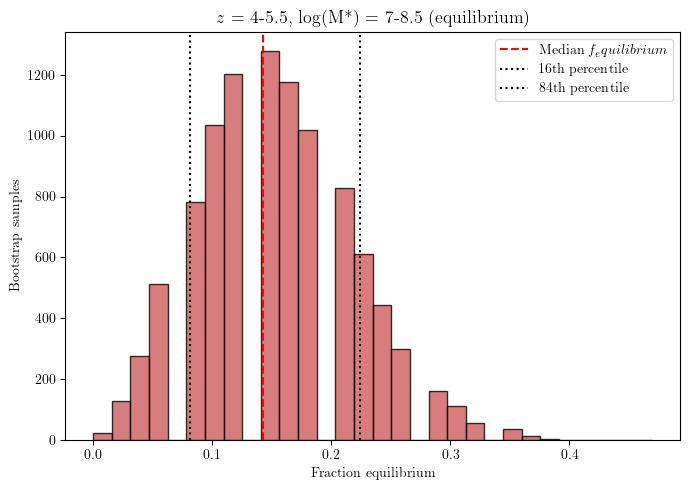

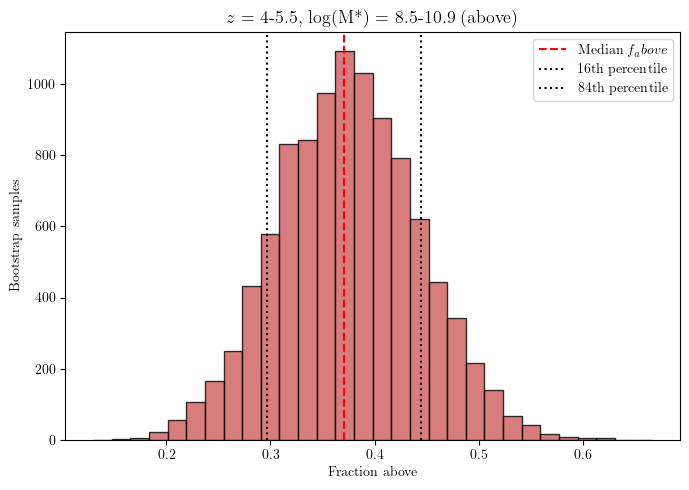

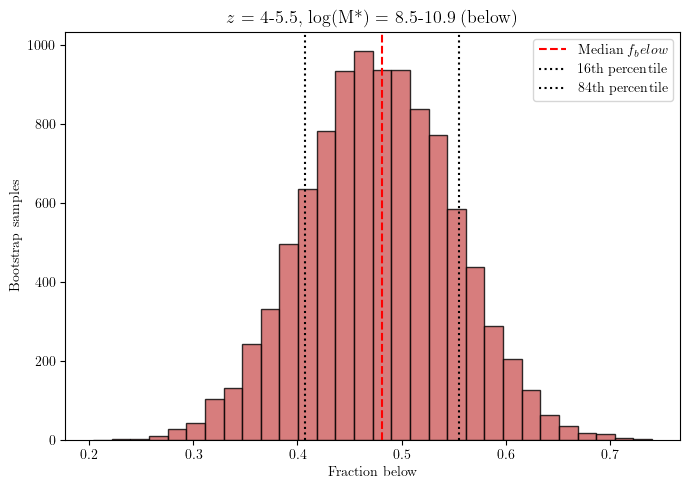

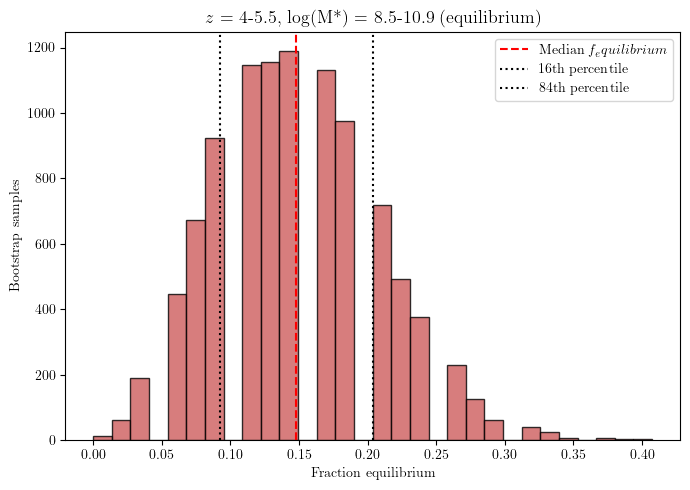

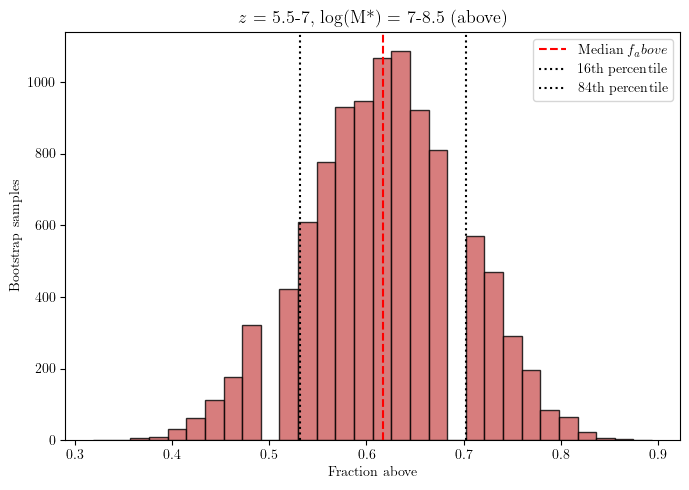

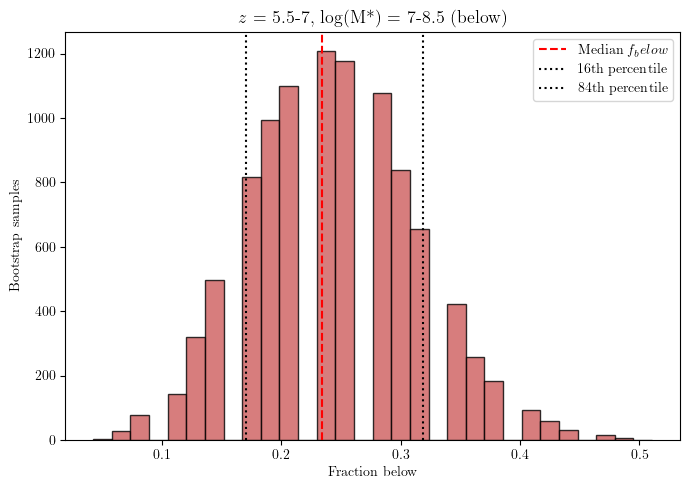

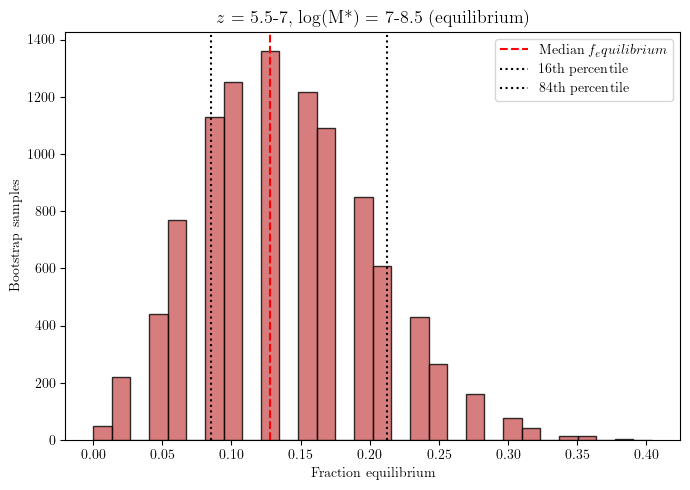

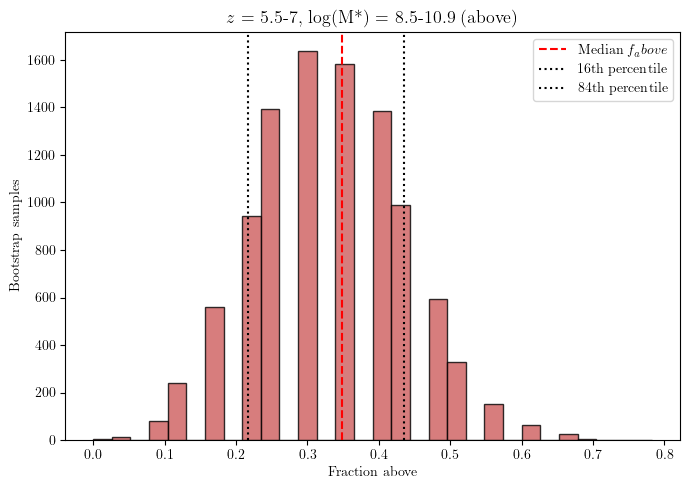

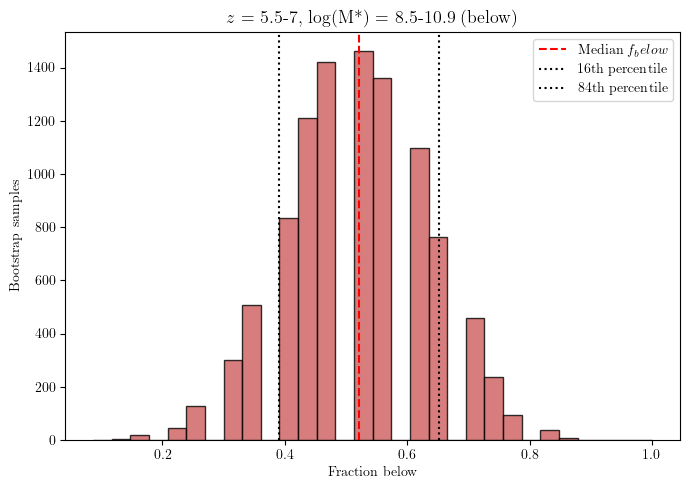

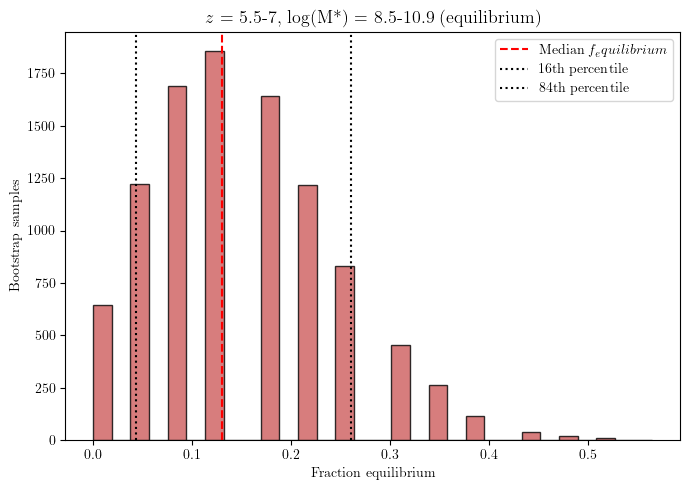

In [21]:
ratio_frac_values = bootstrap_pipeline_frac(sample_df, n_bootstraps=10000)

In [22]:
ratio_frac_values

,Z BIN,MEDIAN Z,Z ERROR LOW,Z ERROR HIGH,MASS BIN,TOTAL SOURCES,FRAC ABOVE,FRAC ABOVE LOWER ERROR,FRAC ABOVE UPPER ERROR,FRAC BELOW,FRAC BELOW LOWER ERROR,FRAC BELOW UPPER ERROR,FRAC EQUILIBRIUM,FRAC EQUILIBRIUM LOWER ERROR,FRAC EQUILIBRIUM UPPER ERROR
0,1-2.5,1.699000,0.699000,0.801000,7-8.5,24,0.750000,0.083333,0.083333,0.125000,0.041667,0.083333,0.083333,0.041667,0.125000
1,1-2.5,1.851200,0.851200,0.648800,8.5-10.9,34,0.470588,0.088235,0.088235,0.441176,0.088235,0.088235,0.088235,0.058824,0.058824
2,2.5-4,3.423400,0.923400,0.576600,7-8.5,33,0.696970,0.090909,0.090909,0.151515,0.060606,0.090909,0.121212,0.060606,0.090909
3,2.5-4,3.471000,0.971000,0.529000,8.5-10.9,79,0.379747,0.050633,0.063291,0.468354,0.063291,0.063291,0.139241,0.037975,0.050633
4,4-5.5,4.628411,0.628411,0.871589,7-8.5,49,0.510204,0.081633,0.061224,0.346939,0.081633,0.081633,0.142857,0.061224,0.081633
5,4-5.5,4.827050,0.827050,0.672950,8.5-10.9,54,0.370370,0.074074,0.074074,0.481481,0.074074,0.074074,0.148148,0.055556,0.055556
6,5.5-7,6.187200,0.687200,0.812800,7-8.5,47,0.617021,0.085106,0.085106,0.234043,0.063830,0.085106,0.127660,0.042553,0.085106
7,5.5-7,6.110000,0.610000,0.890000,8.5-10.9,23,0.347826,0.130435,0.086957,0.521739,0.130435,0.130435,0.130435,0.086957,0.130435


In [23]:
def bootstrap_pipeline_frac_full(sample_df, n_bootstraps=100):
    '''
    Computes the fraction of sources above, below, and within an equilibrium threshold
    for two stellar mass bins: low (<10^8.5) and high (≥10^8.5), across all redshifts.

    Parameters:
        sample_df (DataFrame): contains 'MASS MEDIAN', 'LOG H-ALPHA-TO-UV LUMINOSITY RATIO', and associated ERROR
        n_bootstraps (int): number of bootstrap iterations

    Returns:
        DataFrame: summary stats for low and high mass bins
    '''
    equil_lower = -1.93
    equil_upper = -1.78

    mass_bins = {
        'low': sample_df[sample_df['MASS MEDIAN'] < 8.5],
        'high': sample_df[sample_df['MASS MEDIAN'] >= 8.5]
    }

    summary = {
        'MASS BIN': [],
        'TOTAL SOURCES': [],
        'FRAC ABOVE': [],
        'FRAC ABOVE LOWER ERROR': [],
        'FRAC ABOVE UPPER ERROR': [],
        'FRAC BELOW': [],
        'FRAC BELOW LOWER ERROR': [],
        'FRAC BELOW UPPER ERROR': [],
        'FRAC EQUILIBRIUM': [],
        'FRAC EQUILIBRIUM LOWER ERROR': [],
        'FRAC EQUILIBRIUM UPPER ERROR': [],
    }

    for label, mass_bin_df in mass_bins.items():
        if mass_bin_df.empty:
            continue

        log_lum_ratio = mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'].values
        log_lum_ratio_err = mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR'].values
        total = len(log_lum_ratio)

        # Bootstrap arrays
        bootstrap_above = []
        bootstrap_below = []
        bootstrap_within = []

        for _ in range(n_bootstraps):
            perturbed = log_lum_ratio + np.random.normal(loc=0.0, scale=log_lum_ratio_err)
            resampled = np.random.choice(perturbed, size=total, replace=True)

            res_above = np.sum(resampled > equil_upper) / total
            res_below = np.sum(resampled < equil_lower) / total
            res_within = np.sum((resampled > equil_lower) & (resampled < equil_upper)) / total

            bootstrap_above.append(res_above)
            bootstrap_below.append(res_below)
            bootstrap_within.append(res_within)

        # Compute central value as the median
        frac_above = np.median(bootstrap_above)
        frac_below = np.median(bootstrap_below)
        frac_within = np.median(bootstrap_within)

        # Compute non-symmetric error bars from percentiles
        p16_above, p84_above = np.percentile(bootstrap_above, [16, 84])
        p16_below, p84_below = np.percentile(bootstrap_below, [16, 84])
        p16_within, p84_within = np.percentile(bootstrap_within, [16, 84])

        # Plot histogram
        plt.figure()
        plt.hist(bootstrap_above, bins=30, alpha=0.7, color='tomato', edgecolor='k')
        plt.axvline(frac_above, color='red', linestyle='--', label='Median $f_{\\rm above}$')
        plt.axvline(p16_above, color='k', linestyle=':', label='16th percentile')
        plt.axvline(p84_above, color='k', linestyle=':', label='84th percentile')
        plt.title(f"Bootstrap Distribution: $f_{{\\rm above}}$ ({label}-mass, N={total})")
        plt.xlabel("Fraction")
        plt.ylabel("Bootstrap Samples")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Append results
        summary['MASS BIN'].append('log(M*) < 8.5' if label == 'low' else 'log(M*) ≥ 8.5')
        summary['TOTAL SOURCES'].append(total)

        summary['FRAC ABOVE'].append(frac_above)
        summary['FRAC ABOVE LOWER ERROR'].append(frac_above - p16_above)
        summary['FRAC ABOVE UPPER ERROR'].append(p84_above - frac_above)

        summary['FRAC BELOW'].append(frac_below)
        summary['FRAC BELOW LOWER ERROR'].append(frac_below - p16_below)
        summary['FRAC BELOW UPPER ERROR'].append(p84_below - frac_below)

        summary['FRAC EQUILIBRIUM'].append(frac_within)
        summary['FRAC EQUILIBRIUM LOWER ERROR'].append(frac_within - p16_within)
        summary['FRAC EQUILIBRIUM UPPER ERROR'].append(p84_within - frac_within)

    return pd.DataFrame(summary)

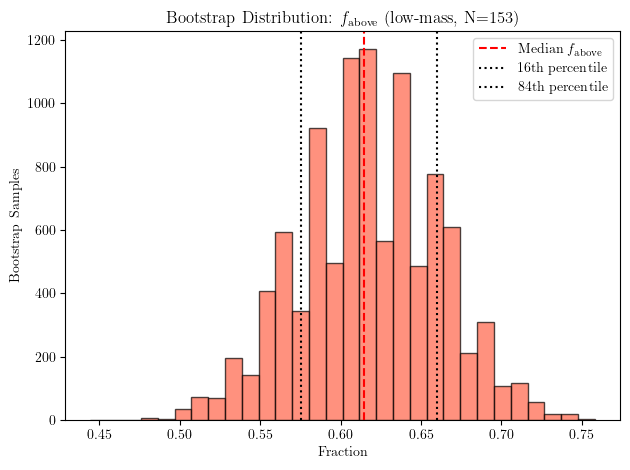

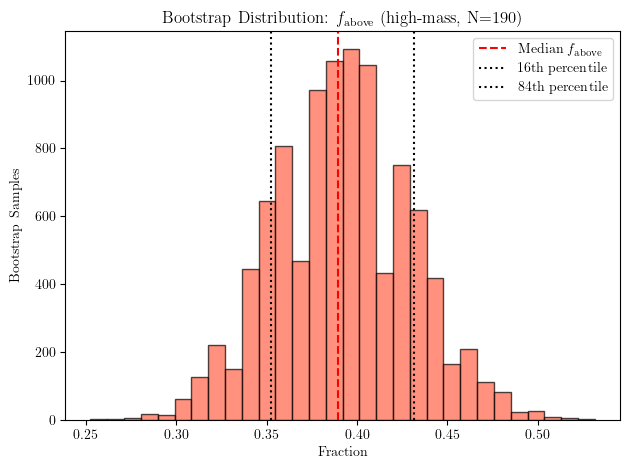

In [24]:
summary_df = bootstrap_pipeline_frac_full(sample_df, n_bootstraps=10000)

In [25]:
summary_df

,MASS BIN,TOTAL SOURCES,FRAC ABOVE,FRAC ABOVE LOWER ERROR,FRAC ABOVE UPPER ERROR,FRAC BELOW,FRAC BELOW LOWER ERROR,FRAC BELOW UPPER ERROR,FRAC EQUILIBRIUM,FRAC EQUILIBRIUM LOWER ERROR,FRAC EQUILIBRIUM UPPER ERROR
0,log(M*) < 8.5,153,0.614379,0.039216,0.045752,0.241830,0.032680,0.039216,0.137255,0.032680,0.039216
1,log(M*) ≥ 8.5,190,0.389474,0.036842,0.042105,0.473684,0.036842,0.036842,0.131579,0.026316,0.036842


In [26]:
# ----- COMBINE ABOVE + BELOW -----
summary_df['ABOVE+BELOW'] = summary_df['FRAC ABOVE'] + summary_df['FRAC BELOW']

# Combine asymmetric errors in quadrature (upper and lower separately)
summary_df['ABOVE+BELOW LOWER ERROR'] = np.sqrt(
    summary_df['FRAC ABOVE LOWER ERROR']**2 + summary_df['FRAC BELOW LOWER ERROR']**2
)
summary_df['ABOVE+BELOW UPPER ERROR'] = np.sqrt(
    summary_df['FRAC ABOVE UPPER ERROR']**2 + summary_df['FRAC BELOW UPPER ERROR']**2
)

# ----- WEIGHTED COMBINED FRACTION (all galaxies) -----
total_sources = summary_df['TOTAL SOURCES'].sum()
weighted_frac = np.average(summary_df['ABOVE+BELOW'], weights=summary_df['TOTAL SOURCES'])

# Weighted upper/lower errors
weighted_lower_error = np.sqrt(np.sum((summary_df['TOTAL SOURCES'] * summary_df['ABOVE+BELOW LOWER ERROR'])**2)) / total_sources
weighted_upper_error = np.sqrt(np.sum((summary_df['TOTAL SOURCES'] * summary_df['ABOVE+BELOW UPPER ERROR'])**2)) / total_sources

print(f"Combined fraction (above+below): {weighted_frac:.3f} -{weighted_lower_error:.3f} +{weighted_upper_error:.3f}")

Combined fraction (above+below): 0.860 -0.037 +0.041


In [27]:
# ----- LOW-MASS BIN -----
low_mass = summary_df[summary_df['MASS BIN'] == 'log(M*) < 8.5'].iloc[0]
low_comb_frac = low_mass['FRAC ABOVE'] + low_mass['FRAC BELOW']
low_comb_lower_err = np.sqrt(low_mass['FRAC ABOVE LOWER ERROR']**2 + low_mass['FRAC BELOW LOWER ERROR']**2)
low_comb_upper_err = np.sqrt(low_mass['FRAC ABOVE UPPER ERROR']**2 + low_mass['FRAC BELOW UPPER ERROR']**2)

print(f"Low-mass (log(M*) < 8.5): above+below = {low_comb_frac:.3f} -{low_comb_lower_err:.3f} +{low_comb_upper_err:.3f}")

Low-mass (log(M*) < 8.5): above+below = 0.856 -0.051 +0.060


In [28]:
# ----- HIGH-MASS BIN -----
high_mass = summary_df[summary_df['MASS BIN'] == 'log(M*) ≥ 8.5'].iloc[0]
high_comb_frac = high_mass['FRAC ABOVE'] + high_mass['FRAC BELOW']
high_comb_lower_err = np.sqrt(high_mass['FRAC ABOVE LOWER ERROR']**2 + high_mass['FRAC BELOW LOWER ERROR']**2)
high_comb_upper_err = np.sqrt(high_mass['FRAC ABOVE UPPER ERROR']**2 + high_mass['FRAC BELOW UPPER ERROR']**2)

print(f"High-mass (log(M*) ≥ 8.5): above+below = {high_comb_frac:.3f} -{high_comb_lower_err:.3f} +{high_comb_upper_err:.3f}")

High-mass (log(M*) ≥ 8.5): above+below = 0.863 -0.052 +0.056


# Redshift comparison of fractional values

In [29]:
# Subset by redshift bins
low_z = ratio_frac_values[ratio_frac_values['Z BIN'] == '1-2.5']
high_z = ratio_frac_values[ratio_frac_values['Z BIN'] == '5.5-7']

# Store results
rows = []

# Loop over mass bins and compute delta f for each type
for mass_bin in ['7-8.5', '8.5-10.9']:
    low = low_z[low_z['MASS BIN'] == mass_bin].iloc[0]
    high = high_z[high_z['MASS BIN'] == mass_bin].iloc[0]

    for frac_type in ['FRAC ABOVE', 'FRAC BELOW', 'FRAC EQUILIBRIUM']:
        delta = high[frac_type] - low[frac_type]

        # Column names for upper/lower error
        err_lower = frac_type + ' LOWER ERROR'
        err_upper = frac_type + ' UPPER ERROR'

        # Compute asymmetric errors for delta
        delta_lower_err = np.sqrt(low[err_lower]**2 + high[err_upper]**2)
        delta_upper_err = np.sqrt(low[err_upper]**2 + high[err_lower]**2)

        rows.append({
            'Mass Bin': mass_bin,
            'Fraction Type': frac_type.replace('FRAC ', '').capitalize(),
            'Delta f': delta,
            'Delta f Lower Error': delta_lower_err,
            'Delta f Upper Error': delta_upper_err
        })

delta_f_df = pd.DataFrame(rows)
delta_f_df

,Mass Bin,Fraction Type,Delta f,Delta f Lower Error,Delta f Upper Error
0,7-8.5,Above,-0.132979,0.119111,0.119111
1,7-8.5,Below,0.109043,0.094759,0.104970
2,7-8.5,Equilibrium,0.044326,0.094759,0.132045
3,8.5-10.9,Above,-0.122762,0.123883,0.157476
4,8.5-10.9,Below,0.080563,0.157476,0.157476
5,8.5-10.9,Equilibrium,0.042199,0.143085,0.104984


# Fraction for literature values

In [30]:
# Function to compute midpoint from a 'x-y' bin string
def bin_midpoint(bin_str):
    zmin, zmax = map(float, bin_str.split('-'))
    return (zmin + zmax) / 2


# literature values (already calculated)
z_vals = ['1.4-2.7','2.7-4','4-5','5-6','6-7']
equilibrium = [0.54,0.71,0.52,0.48,0.64] 
above = [0.13,0.13,0.32,0.17,0.21]  
below = [0.33,0.16,0.16,0.35,0.14]  

ratio_frac_values_Clarke2024 = pd.DataFrame()
ratio_frac_values_Clarke2024['Z BIN'] = z_vals
ratio_frac_values_Clarke2024['Z BIN MIDPOINT'] = ratio_frac_values_Clarke2024['Z BIN'].apply(bin_midpoint)
ratio_frac_values_Clarke2024['FRAC ABOVE'] = above
ratio_frac_values_Clarke2024['FRAC BELOW'] = below
ratio_frac_values_Clarke2024['FRAC EQUILIBRIUM'] = equilibrium
ratio_frac_values_Clarke2024

,Z BIN,Z BIN MIDPOINT,FRAC ABOVE,FRAC BELOW,FRAC EQUILIBRIUM
0,1.4-2.7,2.05,0.13,0.33,0.54
1,2.7-4,3.35,0.13,0.16,0.71
2,4-5,4.50,0.32,0.16,0.52
3,5-6,5.50,0.17,0.35,0.48
4,6-7,6.50,0.21,0.14,0.64


In [31]:
ratio_frac_values.to_csv('../outputs/checkpoints/ratio_frac_values.csv',index=False)
ratio_frac_values_Clarke2024.to_csv('../outputs/checkpoints/ratio_frac_values_Clarke2024.csv',index=False)

In [32]:
sample_df.to_pickle('../outputs/checkpoints/sample_computation.pkl')
sample_df

,MSA ID,SURVEY,SPECTRA TYPE,Z SPEC,RA,H-ALPHA-TO-UV LUMINOSITY RATIO,H-ALPHA-TO-UV LUMINOSITY RATIO ERROR,LOG H-ALPHA-TO-UV LUMINOSITY RATIO,LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR,DEC,...,UV LUMINOSITY DUST-CORRECTED 16% ERROR,UV LUMINOSITY DENSITY DUST-CORRECTED MEDIAN,UV LUMINOSITY DUST-CORRECTED MEDIAN,UV LUMINOSITY DENSITY DUST-CORRECTED 84% ERROR,UV LUMINOSITY DUST-CORRECTED 84% ERROR,UV LUMINOSITY DENSITY DUST-CORRECTED MEAN ERROR,UV LUMINOSITY DUST-CORRECTED MEAN ERROR,UV LUMINOSITY SNR,Z BIN,MASS BIN
171,35478,RUBIES,PRISM,1.801400,214.855202,0.027795,0.001464,-1.556032,0.022869,52.814632,...,6.265330e+42,9.504448e+28,1.899575e+44,9.857593e+28,7.058018e+42,3.333143e+27,6.661674e+42,28.514974,1-2.5,8.5-10.9
78,17463,CEERS,GRATING,2.302000,215.050125,0.036476,0.003176,-1.437987,0.037810,52.941961,...,3.020991e+41,2.775813e+27,5.547786e+42,2.922153e+27,2.924763e+41,1.487468e+26,2.972877e+41,18.661337,1-2.5,7-8.5
198,41376,RUBIES,PRISM,2.302900,214.829378,0.028052,0.001831,-1.552040,0.028340,52.811732,...,7.074261e+41,9.093697e+27,1.817481e+43,9.523405e+27,8.588206e+41,3.918327e+26,7.831233e+41,23.208111,1-2.5,7-8.5
208,42538,RUBIES,PRISM,1.987400,34.271604,0.004917,0.000902,-2.308338,0.079701,-5.242305,...,4.077098e+42,6.217381e+28,1.242616e+44,6.400742e+28,3.664683e+42,1.936785e+27,3.870891e+42,32.101552,1-2.5,8.5-10.9
67,10293,CEERS,GRATING,1.676000,214.872556,0.130381,0.039518,-0.884784,0.131632,52.875949,...,3.646991e+41,1.013135e+27,2.024868e+42,1.271612e+27,5.165964e+41,2.204764e+26,4.406477e+41,4.595208,1-2.5,8.5-10.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,32524,RUBIES,PRISM,5.648329,214.820636,0.017122,0.002413,-1.766442,0.061212,52.783304,...,2.666465e+42,1.527232e+28,3.052350e+43,1.665509e+28,2.763641e+42,1.358466e+27,2.715053e+42,11.242323,5.5-7,7-8.5
164,32291,RUBIES,PRISM,6.584500,214.831575,0.013576,0.003864,-1.867232,0.123610,52.790551,...,5.512506e+42,2.087025e+28,4.171163e+43,2.375488e+28,5.765257e+42,2.821392e+27,5.638881e+42,7.397146,5.5-7,7-8.5
159,30434,RUBIES,PRISM AND GRATING,5.678600,34.270243,0.006847,0.001548,-2.164500,0.098185,-5.262327,...,1.017703e+43,4.888963e+28,9.771161e+43,5.322062e+28,8.655985e+42,4.711514e+27,9.416510e+42,10.376627,5.5-7,7-8.5
209,42573,RUBIES,GRATING,6.493300,214.970177,0.008580,0.000709,-2.066492,0.035904,52.916446,...,4.701082e+42,7.473766e+28,1.493719e+44,7.755796e+28,5.636700e+42,2.586235e+27,5.168891e+42,28.898252,5.5-7,7-8.5
